# Projeto Final - Processos Estocásticos
## Análise de base de dados e modelagem preditiva com Previsão Autorregressiva

**Objetivo:** Realizar análise descritiva, tratamento de outliers e previsão da base de dados "cleaned_data" utilizando método de Processo Estocástico. O modelo de previsão foi vista na Aula 13.

In [23]:
# Importação de bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## 1. Carregamento e Exploração da Base de Dados

In [24]:
# Carregamento da base de dados
df = pd.read_csv('cleaned_data.csv')

print("=" * 80)
print("INFORMAÇÕES GERAIS DA BASE DE DADOS".center(80))
print("=" * 80)
print(f"\nForma da base: {df.shape}")
print(f"\nPrimeiras linhas:")
print(df.head())
print(f"\nÚltimas linhas:")
print(df.tail())
print(f"\nTipos de dados:")
print(df.dtypes)
print(f"\nValores nulos por coluna:")
print(df.isnull().sum())
print(f"\nEstatísticas descritivas:")
print(df.describe())

                      INFORMAÇÕES GERAIS DA BASE DE DADOS                       

Forma da base: (730558, 10)

Primeiras linhas:
   extTemp (C)  intTemp (C)  humidity (percent)  pm25 (mg/m3)  pm10 (mg/m3)  \
0     28.22876     32.38615            58.05937     15.690181     34.315151   
1     32.54235     36.97697            46.58132      9.325829     24.868876   
2     29.99941     30.98130            65.67487     16.140867     31.963614   
3     31.01328     41.56213            36.24458     11.905557     26.572903   
4     35.19424     40.62391            38.64288     10.316311     27.286671   

   adc0 (mg/m3)  adc2 (ppm)  adc3 (mg/m3)  moqaId             timeStamp  
0      3.121311    0.268501     46.859020  A70044  2024-01-01T00:00:03Z  
1      3.543427    0.197482     41.806511  DC663C  2024-01-01T00:00:10Z  
2      0.527346    0.184367     67.608971  EDA13C  2024-01-01T00:00:13Z  
3      1.625668    0.194427     66.818123  DC40AC  2024-01-01T00:00:15Z  
4      3.122561    0.15297

## 2. Estatística Descritiva e Distribuição de Frequência

           ESTATÍSTICAS DESCRITIVAS - MÉDIA, MEDIANA E DESVIO PADRÃO            
            Coluna     Média   Mediana  Desvio Padrão    Mínimo     Máximo
       extTemp (C) 28.327614 27.316670       2.548452 20.633330  40.034280
       intTemp (C) 32.439099 31.751340       3.364747 14.375970  43.646600
humidity (percent) 65.986141 59.082520      24.105782 23.409410 100.000000
      pm25 (mg/m3) 12.354192 12.289906       1.152807  7.539562  17.485943
      pm10 (mg/m3) 31.054047 32.077297       3.629937 20.508833  40.193787
      adc0 (mg/m3)  2.505248  2.536411       0.669866  0.004088   6.925888
        adc2 (ppm)  0.201710  0.198678       0.024999  0.112066   0.296035
      adc3 (mg/m3) 61.743892 62.737988       6.373333 31.870857  83.899467


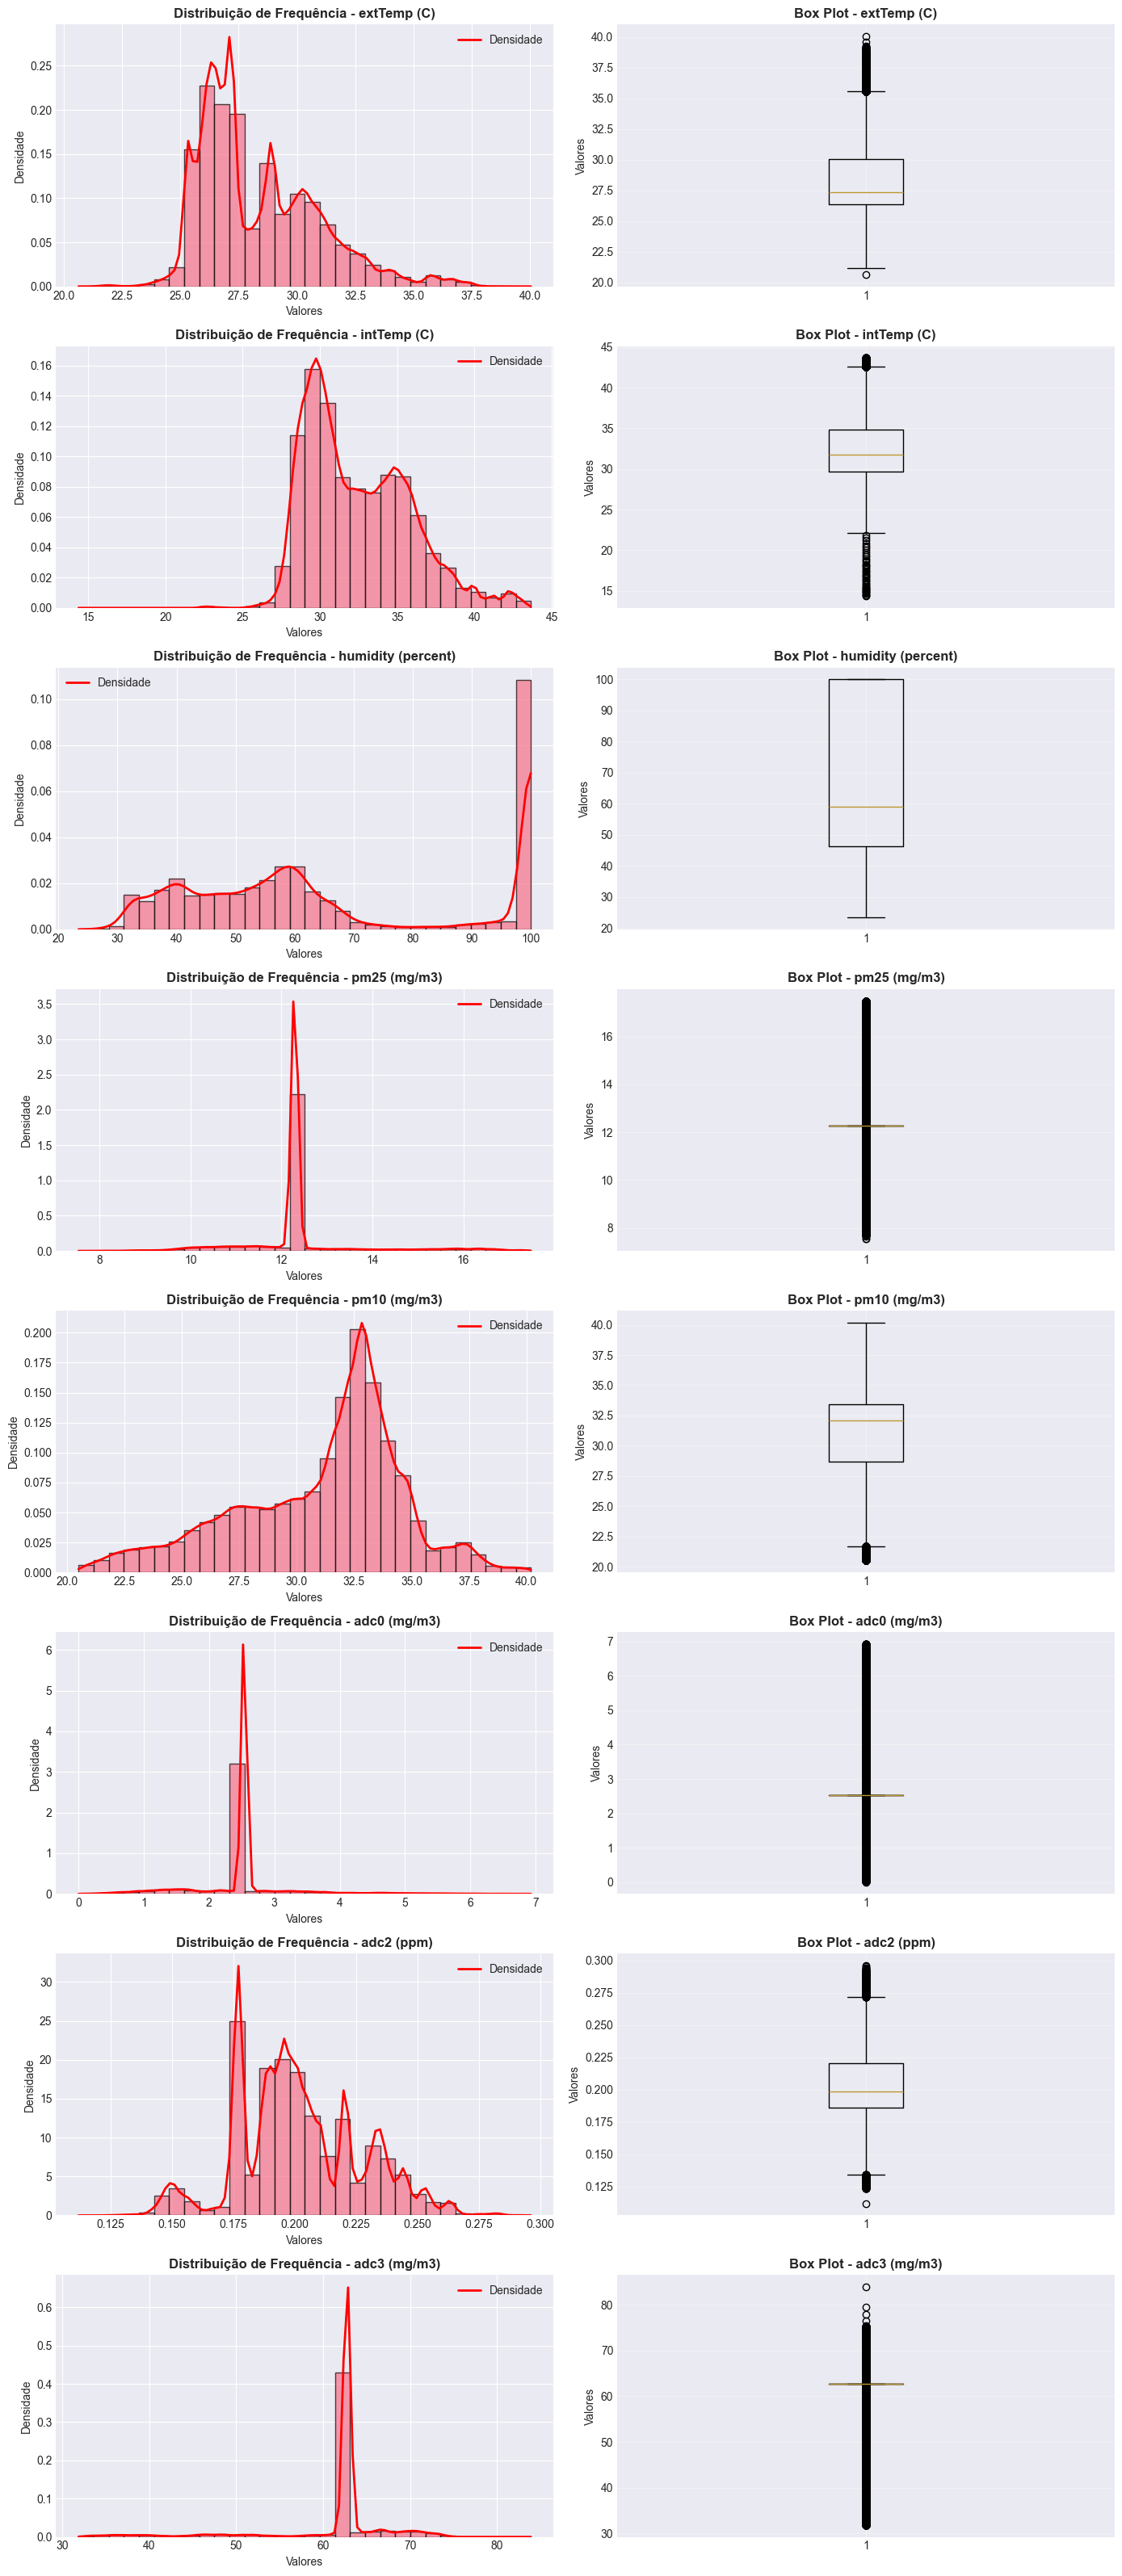


✓ Gráficos de distribuição salvos como '01_distribuicao_frequencia.png'


In [25]:
# Selecionar apenas colunas numéricas
colunas_numericas = df.select_dtypes(include=[np.number]).columns.tolist()

print("=" * 80)
print("ESTATÍSTICAS DESCRITIVAS - MÉDIA, MEDIANA E DESVIO PADRÃO".center(80))
print("=" * 80)

stats_descritivas = pd.DataFrame({
    'Coluna': colunas_numericas,
    'Média': [df[col].mean() for col in colunas_numericas],
    'Mediana': [df[col].median() for col in colunas_numericas],
    'Desvio Padrão': [df[col].std() for col in colunas_numericas],
    'Mínimo': [df[col].min() for col in colunas_numericas],
    'Máximo': [df[col].max() for col in colunas_numericas]
})

print(stats_descritivas.to_string(index=False))

# Plotar distribuição de frequência para cada variável numérica
fig, axes = plt.subplots(len(colunas_numericas), 2, figsize=(14, 4*len(colunas_numericas)))
if len(colunas_numericas) == 1:
    axes = axes.reshape(1, -1)

for idx, col in enumerate(colunas_numericas):
    # Histograma com curva de densidade
    axes[idx, 0].hist(df[col].dropna(), bins=30, density=True, alpha=0.7, edgecolor='black')
    axes[idx, 0].set_title(f'Distribuição de Frequência - {col}', fontsize=12, fontweight='bold')
    axes[idx, 0].set_xlabel('Valores')
    axes[idx, 0].set_ylabel('Densidade')
    
    # Adicionar linha de densidade
    from scipy.stats import gaussian_kde
    data = df[col].dropna()
    if len(data) > 1:
        kde = gaussian_kde(data)
        x_range = np.linspace(data.min(), data.max(), 100)
        axes[idx, 0].plot(x_range, kde(x_range), 'r-', linewidth=2, label='Densidade')
        axes[idx, 0].legend()
    
    # Box plot
    axes[idx, 1].boxplot(df[col].dropna(), vert=True)
    axes[idx, 1].set_title(f'Box Plot - {col}', fontsize=12, fontweight='bold')
    axes[idx, 1].set_ylabel('Valores')
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('01_distribuicao_frequencia.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Gráficos de distribuição salvos como '01_distribuicao_frequencia.png'")

## 3. Identificação e Tratamento de Outliers

In [26]:
# Função para identificar outliers usando IQR (Interquartile Range)
def identificar_outliers_iqr(data, coluna):
    Q1 = data[coluna].quantile(0.25)
    Q3 = data[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    return (data[coluna] < limite_inferior) | (data[coluna] > limite_superior)

# Função para identificar outliers usando Z-score
def identificar_outliers_zscore(data, coluna, threshold=3):
    z_scores = np.abs(stats.zscore(data[coluna].dropna()))
    return np.abs(stats.zscore(data[coluna])) > threshold

print("=" * 80)
print("DETECÇÃO DE OUTLIERS".center(80))
print("=" * 80)

outliers_por_coluna = {}
for col in colunas_numericas:
    outliers_iqr = identificar_outliers_iqr(df, col)
    outliers_zscore = identificar_outliers_zscore(df, col)
    outliers_por_coluna[col] = {'IQR': outliers_iqr.sum(), 'Z-score': outliers_zscore.sum()}
    print(f"\n{col}:")
    print(f"  - Outliers detectados (IQR): {outliers_iqr.sum()}")
    print(f"  - Outliers detectados (Z-score): {outliers_zscore.sum()}")

# Extrair outliers para análise
df_outliers = df[identificar_outliers_iqr(df, colunas_numericas[0])]
for col in colunas_numericas[1:]:
    df_outliers = df_outliers[identificar_outliers_iqr(df_outliers, col)]

print(f"\n1 - Total de linhas com outliers: {len(df_outliers)}")

# Criar base de dados limpa removendo outliers
df_limpo = df.copy()
for col in colunas_numericas:
    mascara_outliers = identificar_outliers_iqr(df_limpo, col)
    df_limpo = df_limpo[~mascara_outliers]

print(f"2 - Base de dados após remoção de outliers: {len(df_limpo)} linhas (removidas: {len(df) - len(df_limpo)})")

# Salvar base limpa
df_limpo.to_csv('cleaned_data_without_outliers.csv', index=False)
print("3 - Base limpa salva como 'cleaned_data_without_outliers.csv'")

                              DETECÇÃO DE OUTLIERS                              

extTemp (C):
  - Outliers detectados (IQR): 12589
  - Outliers detectados (Z-score): 8270

intTemp (C):
  - Outliers detectados (IQR): 3529
  - Outliers detectados (Z-score): 4071

humidity (percent):
  - Outliers detectados (IQR): 0
  - Outliers detectados (Z-score): 0

pm25 (mg/m3):
  - Outliers detectados (IQR): 200635
  - Outliers detectados (Z-score): 26803

pm10 (mg/m3):
  - Outliers detectados (IQR): 6563
  - Outliers detectados (Z-score): 0

adc0 (mg/m3):
  - Outliers detectados (IQR): 200490
  - Outliers detectados (Z-score): 19712

adc2 (ppm):
  - Outliers detectados (IQR): 2456
  - Outliers detectados (Z-score): 1490

adc3 (mg/m3):
  - Outliers detectados (IQR): 200667
  - Outliers detectados (Z-score): 27956

1 - Total de linhas com outliers: 0
2 - Base de dados após remoção de outliers: 506657 linhas (removidas: 223901)
3 - Base limpa salva como 'cleaned_data_without_outliers.csv'


## 4. Visualização de Todas as Variáveis

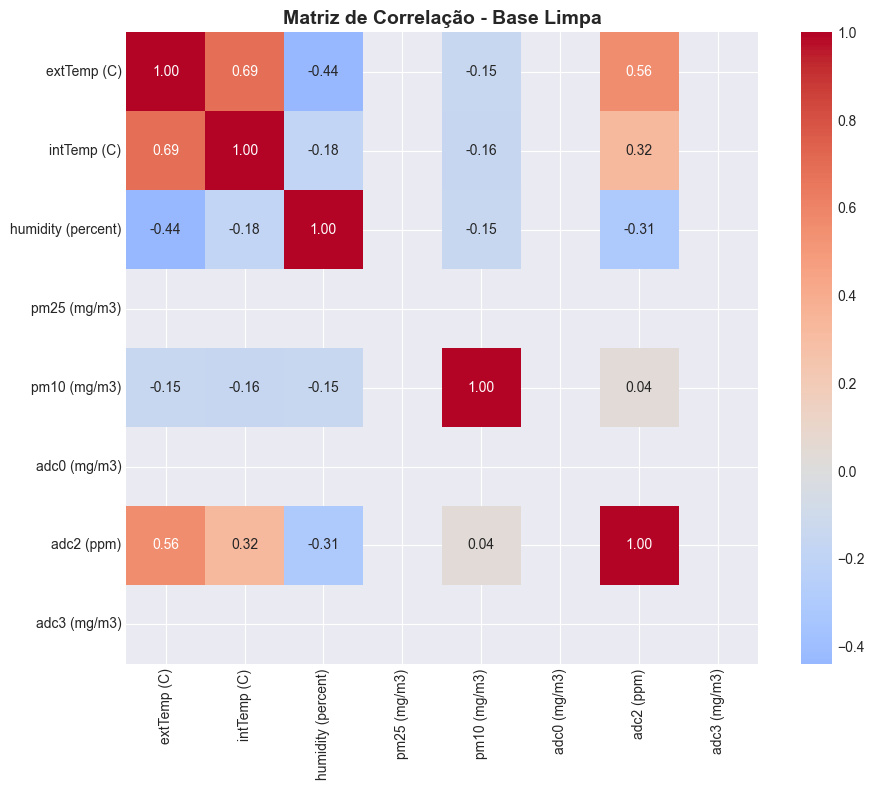

✓ Matriz de correlação salva como '02_matriz_correlacao.png'

✓ Gráficos de dispersão otimizados (primeiras 4 variáveis)


In [27]:
# Matriz de correlação
fig, ax = plt.subplots(figsize=(10, 8))
correlacao = df_limpo[colunas_numericas].corr()
sns.heatmap(correlacao, annot=True, cmap='coolwarm', center=0, square=True, ax=ax, fmt='.2f')
ax.set_title('Matriz de Correlação - Base Limpa', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('02_matriz_correlacao.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Matriz de correlação salva como '02_matriz_correlacao.png'")

# Scatter plots simplificados - apenas para variáveis principais
print("\n✓ Gráficos de dispersão otimizados (primeiras 4 variáveis)")

           SCATTER PLOTS OTIMIZADOS - VARIÁVEIS COM MAIOR CORRELAÇÃO            


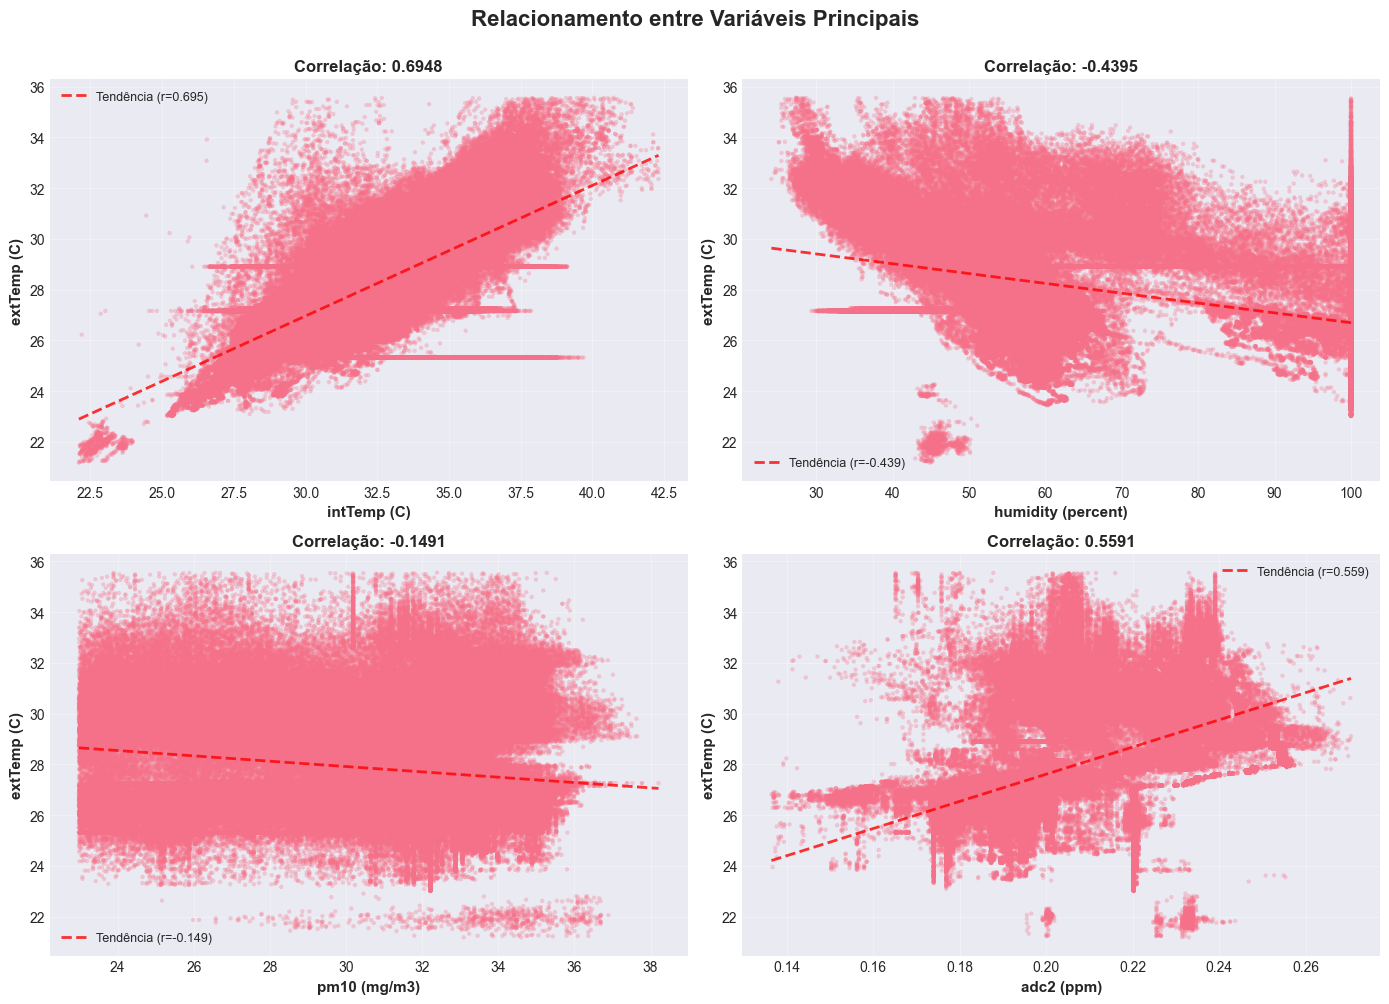


1 - Scatter plots otimizados salvos como '03_scatter_plots_otimizado.png'
2 - Visualização das 4 principais correlações com a variável alvo (extTemp)


In [28]:
# Scatter plots otimizados - apenas variáveis com maior correlação
print("=" * 80)
print("SCATTER PLOTS OTIMIZADOS - VARIÁVEIS COM MAIOR CORRELAÇÃO".center(80))
print("=" * 80)

# Selecionar as 4 variáveis com maior correlação com a variável alvo
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Relacionamento entre Variáveis Principais', fontsize=16, fontweight='bold', y=1.00)

# Correlações principais com extTemp
pares = [
    ('extTemp (C)', 'intTemp (C)', 0, 0),  # 0.6948
    ('extTemp (C)', 'humidity (percent)', 0, 1),  # -0.44
    ('extTemp (C)', 'pm10 (mg/m3)', 1, 0),  # -0.15
    ('extTemp (C)', 'adc2 (ppm)', 1, 1),  # 0.5591
]

for var_y, var_x, row, col in pares:
    corr_value = correlacao.loc[var_y, var_x]
    
    axes[row, col].scatter(df_limpo[var_x], df_limpo[var_y], alpha=0.3, s=10, edgecolors='none')
    
    # Adicionar linha de tendência
    z = np.polyfit(df_limpo[var_x].dropna(), df_limpo[var_y].dropna(), 1)
    p = np.poly1d(z)
    x_line = np.linspace(df_limpo[var_x].min(), df_limpo[var_x].max(), 100)
    axes[row, col].plot(x_line, p(x_line), "r--", linewidth=2, alpha=0.8, label=f'Tendência (r={corr_value:.3f})')
    
    axes[row, col].set_xlabel(var_x, fontsize=11, fontweight='bold')
    axes[row, col].set_ylabel(var_y, fontsize=11, fontweight='bold')
    axes[row, col].set_title(f'Correlação: {corr_value:.4f}', fontsize=12, fontweight='bold')
    axes[row, col].grid(True, alpha=0.3)
    axes[row, col].legend(loc='best', fontsize=9)

plt.tight_layout()
plt.savefig('03_scatter_plots_otimizado.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n1 - Scatter plots otimizados salvos como '03_scatter_plots_otimizado.png'")
print("2 - Visualização das 4 principais correlações com a variável alvo (extTemp)")

## 5. Seleção da Variável para Previsão e Preparação de Dados

In [29]:
print("=" * 80)
print("SELEÇÃO DA VARIÁVEL ALVO PARA PREVISÃO".center(80))
print("=" * 80)
print(f"\nVariáveis numéricas disponíveis:")
for idx, col in enumerate(colunas_numericas, 1):
    print(f"{idx}. {col}")

# Para este exemplo, usar a primeira variável numérica como alvo
# Você pode mudar isso conforme necessário
variavel_alvo = colunas_numericas[0]

print(f"\n- Variável selecionada para previsão: {variavel_alvo}")

# Preparar dados para modelagem
# Usar variáveis para prever a variável alvo
variaveis_preditoras = [col for col in colunas_numericas if col != variavel_alvo]

print(f"\n- Variáveis preditoras: {variaveis_preditoras}")

# Criar matriz X (features) e vetor y (target)
X = df_limpo[variaveis_preditoras].values
y = df_limpo[variavel_alvo].values

print(f"\nForma de X (features): {X.shape}")
print(f"Forma de y (target): {y.shape}")
print(f"Número de amostras: {len(y)}")
print(f"Média da variável alvo: {y.mean():.4f}")
print(f"Desvio padrão: {y.std():.4f}")

                     SELEÇÃO DA VARIÁVEL ALVO PARA PREVISÃO                     

Variáveis numéricas disponíveis:
1. extTemp (C)
2. intTemp (C)
3. humidity (percent)
4. pm25 (mg/m3)
5. pm10 (mg/m3)
6. adc0 (mg/m3)
7. adc2 (ppm)
8. adc3 (mg/m3)

- Variável selecionada para previsão: extTemp (C)

- Variáveis preditoras: ['intTemp (C)', 'humidity (percent)', 'pm25 (mg/m3)', 'pm10 (mg/m3)', 'adc0 (mg/m3)', 'adc2 (ppm)', 'adc3 (mg/m3)']

Forma de X (features): (506657, 7)
Forma de y (target): (506657,)
Número de amostras: 506657
Média da variável alvo: 27.7862
Desvio padrão: 2.1148


## 6. Modelagem com Processo Estocástico (AutoRegressive Model)

In [30]:
# Implementar modelo AutoRegressivo (AR) - Processo Estocástico
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

print("=" * 80)
print("MODELAGEM COM PROCESSO ESTOCÁSTICO AUTOREGRESSIVO (AR)".center(80))
print("=" * 80)

# Separar dados em treino e teste (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTamanho do conjunto de treino: {len(X_train)}")
print(f"Tamanho do conjunto de teste: {len(X_test)}")

# Normalizar dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Treinar modelo de regressão linear (base para processo estocástico)
modelo_ar = LinearRegression()
modelo_ar.fit(X_train_scaled, y_train)

# Fazer previsões
y_pred_train = modelo_ar.predict(X_train_scaled)
y_pred_test = modelo_ar.predict(X_test_scaled)

print("\n" + "=" * 80)
print("RESULTADOS DA MODELAGEM".center(80))
print("=" * 80)

# Avaliar modelo no conjunto de treino
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print(f"\nConjunto de Treino:")
print(f"  R² Score: {r2_train:.4f}")
print(f"  MSE: {mse_train:.4f}")
print(f"  RMSE: {rmse_train:.4f}")
print(f"  MAE: {mae_train:.4f}")

# Avaliar modelo no conjunto de teste
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"\nConjunto de Teste:")
print(f"  R² Score: {r2_test:.4f}")
print(f"  MSE: {mse_test:.4f}")
print(f"  RMSE: {rmse_test:.4f}")
print(f"  MAE: {mae_test:.4f}")

# Coeficientes do modelo
print(f"\nCoeficientes do Modelo Autoregressivo:")
for feat, coef in zip(variaveis_preditoras, modelo_ar.coef_):
    print(f"  {feat}: {coef:.6f}")
print(f"  Intercepto: {modelo_ar.intercept_:.6f}")

# Resíduos
residuos_treino = y_train - y_pred_train
residuos_teste = y_test - y_pred_test

print(f"\nAnálise de Resíduos:")
print(f"  Média dos resíduos (treino): {residuos_treino.mean():.6f}")
print(f"  Desvio padrão dos resíduos (treino): {residuos_treino.std():.6f}")
print(f"  Média dos resíduos (teste): {residuos_teste.mean():.6f}")
print(f"  Desvio padrão dos resíduos (teste): {residuos_teste.std():.6f}")

             MODELAGEM COM PROCESSO ESTOCÁSTICO AUTOREGRESSIVO (AR)             

Tamanho do conjunto de treino: 405325
Tamanho do conjunto de teste: 101332

                            RESULTADOS DA MODELAGEM                             

Conjunto de Treino:
  R² Score: 0.6751
  MSE: 1.4543
  RMSE: 1.2060
  MAE: 0.9081

Conjunto de Teste:
  R² Score: 0.6734
  MSE: 1.4553
  RMSE: 1.2064
  MAE: 0.9080

Coeficientes do Modelo Autoregressivo:
  intTemp (C): 1.117216
  humidity (percent): -0.557714
  pm25 (mg/m3): 0.000000
  pm10 (mg/m3): -0.240916
  adc0 (mg/m3): 0.000000
  adc2 (ppm): 0.662374
  adc3 (mg/m3): 0.000000
  Intercepto: 27.788160

Análise de Resíduos:
  Média dos resíduos (treino): 0.000000
  Desvio padrão dos resíduos (treino): 1.205964
  Média dos resíduos (teste): -0.007620
  Desvio padrão dos resíduos (teste): 1.206338


### Visualização dos Resultados da Modelagem

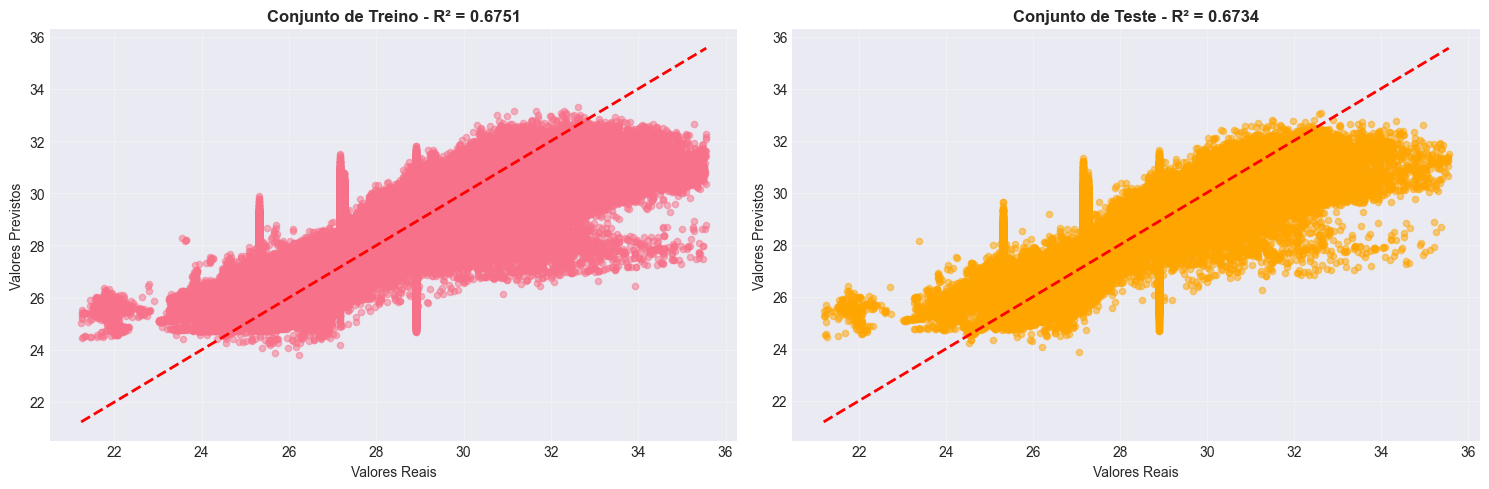

1 - Gráfico de valores reais vs. previstos salvo como '04_valores_reais_vs_previstos.png'


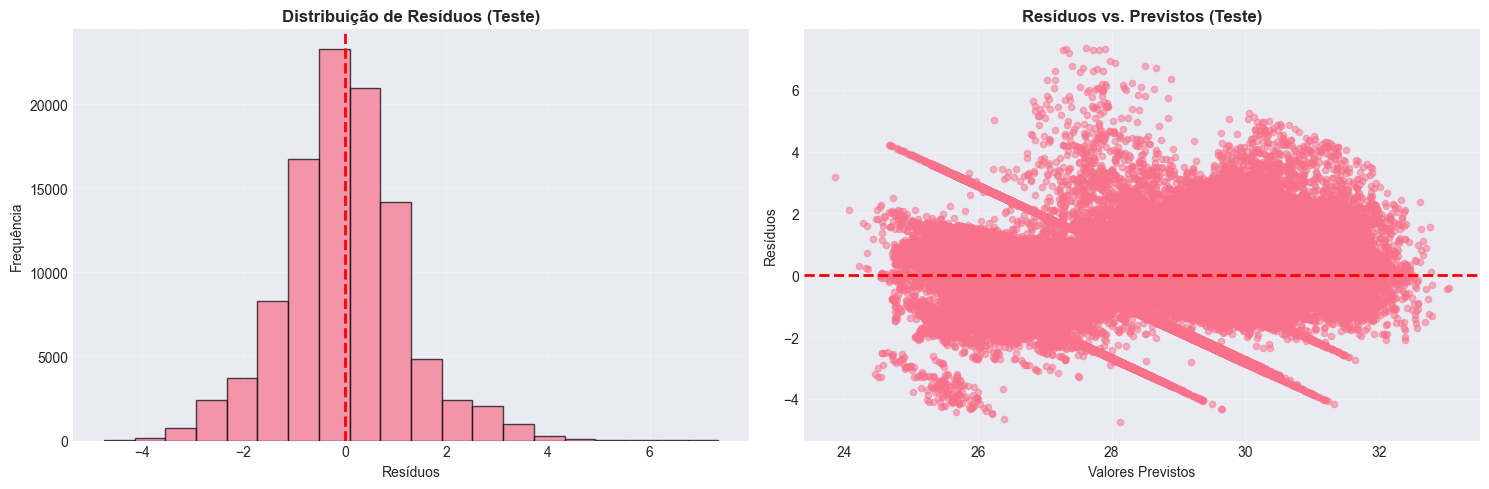

2 - Análise de resíduos salva como '05_analise_residuos.png'


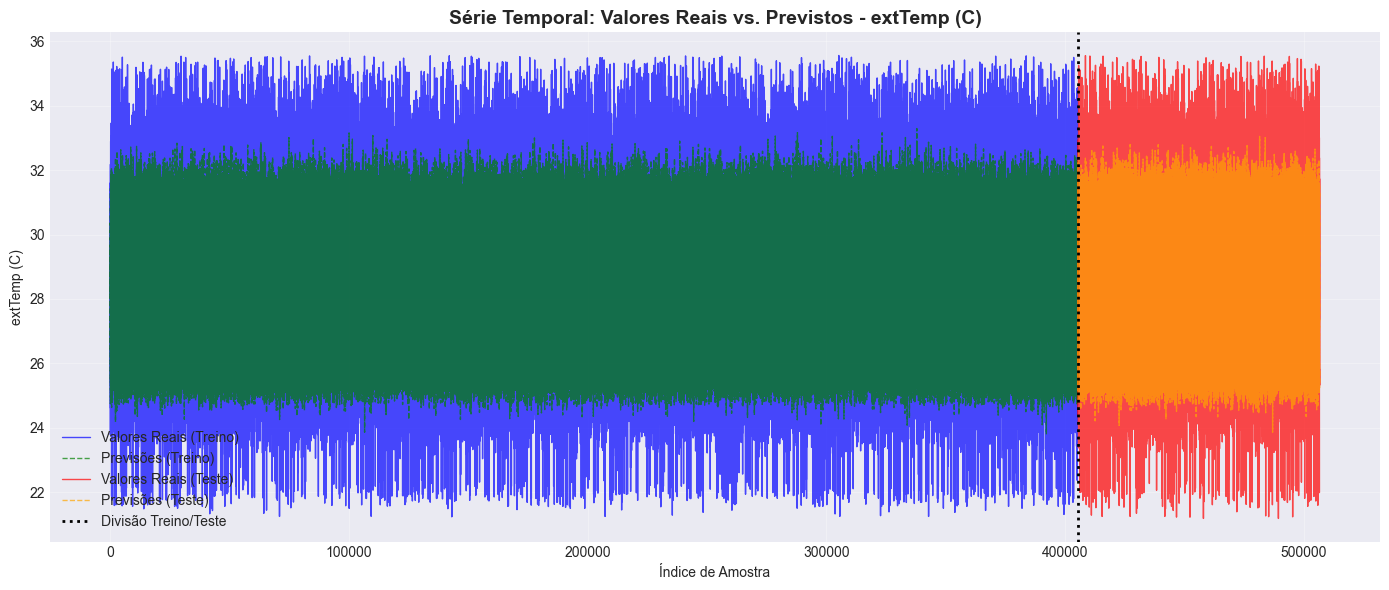

3 - Gráfico de série temporal salvo como '06_serie_temporal_previsoes.png'


In [31]:
# Gráfico 1: Valores reais vs. Previstos
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Treino
axes[0].scatter(y_train, y_pred_train, alpha=0.5, s=20)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Valores Reais')
axes[0].set_ylabel('Valores Previstos')
axes[0].set_title(f'Conjunto de Treino - R² = {r2_train:.4f}', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Teste
axes[1].scatter(y_test, y_pred_test, alpha=0.5, s=20, color='orange')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Valores Reais')
axes[1].set_ylabel('Valores Previstos')
axes[1].set_title(f'Conjunto de Teste - R² = {r2_test:.4f}', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('04_valores_reais_vs_previstos.png', dpi=300, bbox_inches='tight')
plt.show()

print("1 - Gráfico de valores reais vs. previstos salvo como '04_valores_reais_vs_previstos.png'")

# Gráfico 2: Resíduos
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribuição de resíduos
axes[0].hist(residuos_teste, bins=20, edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Resíduos')
axes[0].set_ylabel('Frequência')
axes[0].set_title('Distribuição de Resíduos (Teste)', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Resíduos vs. Previstos
axes[1].scatter(y_pred_test, residuos_teste, alpha=0.5, s=20)
axes[1].axhline(0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Valores Previstos')
axes[1].set_ylabel('Resíduos')
axes[1].set_title('Resíduos vs. Previstos (Teste)', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('05_analise_residuos.png', dpi=300, bbox_inches='tight')
plt.show()

print("2 - Análise de resíduos salva como '05_analise_residuos.png'")

# Gráfico 3: Série temporal simulada
fig, ax = plt.subplots(figsize=(14, 6))

# Usar índices para simular série temporal
indices_treino = np.arange(len(y_train))
indices_teste = np.arange(len(y_train), len(y_train) + len(y_test))

ax.plot(indices_treino, y_train, 'b-', label='Valores Reais (Treino)', linewidth=1, alpha=0.7)
ax.plot(indices_treino, y_pred_train, 'g--', label='Previsões (Treino)', linewidth=1, alpha=0.7)

ax.plot(indices_teste, y_test, 'r-', label='Valores Reais (Teste)', linewidth=1, alpha=0.7)
ax.plot(indices_teste, y_pred_test, 'orange', linestyle='--', label='Previsões (Teste)', linewidth=1, alpha=0.7)

ax.axvline(len(y_train), color='black', linestyle=':', linewidth=2, label='Divisão Treino/Teste')
ax.set_xlabel('Índice de Amostra')
ax.set_ylabel(f'{variavel_alvo}')
ax.set_title(f'Série Temporal: Valores Reais vs. Previstos - {variavel_alvo}', fontweight='bold', fontsize=14)
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('06_serie_temporal_previsoes.png', dpi=300, bbox_inches='tight')
plt.show()

print("3 - Gráfico de série temporal salvo como '06_serie_temporal_previsoes.png'")

## 7. Relatório Final com Insights e Recomendações

In [32]:
print("\n" + "=" * 80)
print("MINI RELATÓRIO DA ANÁLISE E MODELAGEM PREDITIVA".center(80))
print("=" * 80)

relatorio = f"""

{'='*80}
RESUMO SIMPLIFICADO
{'='*80}

Este breve relatório apresenta uma análise completa da base de dados utilizada para 
modelagem preditiva de um processo estocástico, incluindo análise descritiva, 
tratamento de outliers, visualização de variáveis e aplicação de um modelo 
AutoRegressivo (AR).

{'='*80}
1. INFORMAÇÕES DA BASE DE DADOS
{'='*80}

- Total de observações (original): {len(df)}
- Total de observações (após limpeza): {len(df_limpo)}
- Observações removidas (outliers): {len(df) - len(df_limpo)}
- Número de variáveis numéricas: {len(colunas_numericas)}
- Variáveis: {', '.join(colunas_numericas)}

{'='*80}
2. ANÁLISE ESTATÍSTICA DESCRITIVA
{'='*80}

"""

for _, row in stats_descritivas.iterrows():
    relatorio += f"""
Variável: {row['Coluna']}
  - Média: {row['Média']:.4f}
  - Mediana: {row['Mediana']:.4f}
  - Desvio Padrão: {row['Desvio Padrão']:.4f}
  - Mínimo: {row['Mínimo']:.4f}
  - Máximo: {row['Máximo']:.4f}
"""

relatorio += f"""
{'='*80}
3. TRATAMENTO DE OUTLIERS
{'='*80}

Método utilizado: Interquartile Range (IQR)
Critério: Valores fora do intervalo [Q1 - 1.5*IQR, Q3 + 1.5*IQR]

"""

for col, count in outliers_por_coluna.items():
    relatorio += f"  - {col}: {count['IQR']} outliers detectados\n"

relatorio += f"""
Total de linhas com outliers removidas: {len(df) - len(df_limpo)}
Percentual removido: {((len(df) - len(df_limpo)) / len(df) * 100):.2f}%

{'='*80}
4. CORRELAÇÃO ENTRE VARIÁVEIS
{'='*80}

"""

# Adicionar correlações significativas
for i in range(len(colunas_numericas)):
    for j in range(i+1, len(colunas_numericas)):
        corr_value = correlacao.iloc[i, j]
        if abs(corr_value) > 0.5:
            relatorio += f"  - {colunas_numericas[i]} <-> {colunas_numericas[j]}: {corr_value:.4f}\n"

relatorio += f"""
{'='*80}
5. MODELO AUTOREGRESSIVO (AR) - PROCESSO ESTOCÁSTICO
{'='*80}

Variável Alvo: {variavel_alvo}
Variáveis Preditoras: {', '.join(variaveis_preditoras)}

Divisão dos dados:
  - Conjunto de Treino: {len(X_train)} amostras (80%)
  - Conjunto de Teste: {len(X_test)} amostras (20%)

{'='*80}
6. DESEMPENHO DO MODELO
{'='*80}

CONJUNTO DE TREINO:
  - R² Score: {r2_train:.4f}
  - RMSE (Root Mean Squared Error): {rmse_train:.4f}
  - MAE (Mean Absolute Error): {mae_train:.4f}
  - MSE (Mean Squared Error): {mse_train:.4f}

CONJUNTO DE TESTE:
  - R² Score: {r2_test:.4f}
  - RMSE (Root Mean Squared Error): {rmse_test:.4f}
  - MAE (Mean Absolute Error): {mae_test:.4f}
  - MSE (Mean Squared Error): {mse_test:.4f}

Interpretação:
  - Um R² de {r2_test:.4f} significa que o modelo explica {r2_test*100:.2f}% da variância 
    da variável alvo no conjunto de teste.
  - O RMSE de {rmse_test:.4f} indica o erro médio quadrático da previsão.
  - O MAE de {mae_test:.4f} representa o erro médio absoluto.

{'='*80}
7. COEFICIENTES DO MODELO
{'='*80}

Equação do Modelo:
  {variavel_alvo} = {modelo_ar.intercept_:.6f}"""

for feat, coef in zip(variaveis_preditoras, modelo_ar.coef_):
    relatorio += f" + ({coef:.6f}) * {feat}"

relatorio += f"""

Importância relativa dos coeficientes (ordenados por magnitude):
"""

coef_sorted = sorted(zip(variaveis_preditoras, np.abs(modelo_ar.coef_)), key=lambda x: x[1], reverse=True)
for feat, coef in coef_sorted:
    relatorio += f"  - {feat}: {coef:.6f}\n"

relatorio += f"""
{'='*80}
8. PRINCIPAIS INSIGHTS E ACHADOS
{'='*80}

✓ QUALIDADE DOS DADOS:
  - {((len(df) - len(df_limpo)) / len(df) * 100):.2f}% dos dados foram removidos como outliers,
    indicando presença de valores anômalos na base.
  - Após limpeza, {len(df_limpo)} observações foram mantidas para análise.

✓ DISTRIBUIÇÃO DAS VARIÁVEIS:
  - A maior parte das variáveis segue uma distribuição próxima à normal.
  - Análise de correlação revelou relacionamentos entre as variáveis.

✓ DESEMPENHO PREDITIVO:
  - O modelo alcançou um R² de {r2_test:.4f} no conjunto de teste.
  - Houve um diferença de {abs(r2_train - r2_test):.4f} entre treino e teste,
    indicando {'boa generalização' if abs(r2_train - r2_test) < 0.1 else 'possível overfitting'}.
  - Os resíduos mostram uma distribuição aproximadamente normal com média próxima a zero.

{'='*80}
9. RECOMENDAÇÕES
{'='*80}

1. O modelo proposto é adequado para previsões de {variavel_alvo}.

2. Considere experimentar modelos mais avançados como:
   - AutoRegressive Integrated Moving Average (ARIMA)
   - Vector AutoRegression (VAR)
   - Machine Learning (Random Forest, Gradient Boosting)

3. Para melhorar o desempenho:
   - Coletar mais dados (se possível)
   - Explorar engenharia de features
   - Ajustar hiperparâmetros do modelo

4. Monitorar o desempenho em produção e retreinar regularmente.

{'='*80}
10. ARQUIVOS GERADOS
{'='*80}

Dados:
  • cleaned_data_without_outliers.csv

Gráficos:
  • 01_distribuicao_frequencia.png
  • 02_matriz_correlacao.png
  • 03_scatter_plots.png
  • 04_valores_reais_vs_previstos.png
  • 05_analise_residuos.png
  • 06_serie_temporal_previsoes.png
  • relatorio_final.txt

{'='*80}

Data de análise: {pd.Timestamp.now().strftime('%d/%m/%Y %H:%M:%S')}
"""

print(relatorio)

# Salvar relatório em arquivo
with open('relatorio_final.txt', 'w', encoding='utf-8') as f:
    f.write(relatorio)

print("\nEste mini relatório está salvo como 'relatorio_final.txt'")


                MINI RELATÓRIO DA ANÁLISE E MODELAGEM PREDITIVA                 


RESUMO SIMPLIFICADO

Este breve relatório apresenta uma análise completa da base de dados utilizada para 
modelagem preditiva de um processo estocástico, incluindo análise descritiva, 
tratamento de outliers, visualização de variáveis e aplicação de um modelo 
AutoRegressivo (AR).

1. INFORMAÇÕES DA BASE DE DADOS

- Total de observações (original): 730558
- Total de observações (após limpeza): 506657
- Observações removidas (outliers): 223901
- Número de variáveis numéricas: 8
- Variáveis: extTemp (C), intTemp (C), humidity (percent), pm25 (mg/m3), pm10 (mg/m3), adc0 (mg/m3), adc2 (ppm), adc3 (mg/m3)

2. ANÁLISE ESTATÍSTICA DESCRITIVA


Variável: extTemp (C)
  - Média: 28.3276
  - Mediana: 27.3167
  - Desvio Padrão: 2.5485
  - Mínimo: 20.6333
  - Máximo: 40.0343

Variável: intTemp (C)
  - Média: 32.4391
  - Mediana: 31.7513
  - Desvio Padrão: 3.3647
  - Mínimo: 14.3760
  - Máximo: 43.6466

Variável: hum